In [96]:
import numpy as np
from scipy import interpolate
import json
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.interpolate import griddata
import numpy as np
from skimage.feature import corner_harris, peak_local_max
from skimage import io, color
from scipy.spatial.distance import cdist
from skimage.filters import gaussian
from sklearn.neighbors import KDTree
from matplotlib.patches import ConnectionPatch
import math 
import random

In [2]:
def computeH(im1_pts, im2_pts):
    N = im1_pts.shape[0] 
    A = []
    for i in range(N):
        x, y = im1_pts[i]
        x_prime, y_prime = im2_pts[i]

        A.append([x, y, 1, 0, 0, 0, -x * x_prime, -y * x_prime, -x_prime])
        A.append([0, 0, 0, x, y, 1, -x * y_prime, -y * y_prime, y_prime])

    A = np.array(A)

    # Solve for the null space of A using SVD
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape((3, 3))

    H /= H[2, 2]

    return H

In [10]:
with open('correspondance.json', 'r') as f:
    data = json.load(f)

im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])
img1 = plt.imread('images/img1.jpg')
img2 = plt.imread('images/img2.jpg')

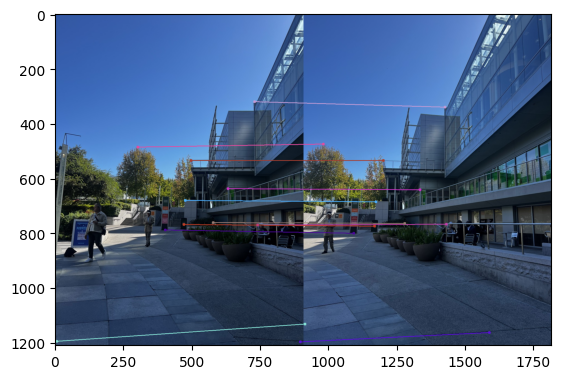

In [240]:
#draw corresponding points
combined_img = np.hstack((img1, img2))
new_points2 = im2_points.copy()
new_points2[:, 0] += img1.shape[1]
for pt1, pt2 in zip(im1_points, new_points2):
    color = tuple(np.random.randint(0, 255, 3).tolist())  # Random color for each line
    cv2.line(combined_img, tuple(pt1), tuple(pt2), color, 2)
    cv2.circle(combined_img, tuple(pt1), 5, color, -1)
    cv2.circle(combined_img, tuple(pt2), 5, color, -1)
plt.imsave('combined_correspondance.jpg', combined_img)
plt.imshow(combined_img)

In [3]:
import numpy as np
from scipy.interpolate import griddata

def warpImage(im, H):
    h, w = im.shape[:2]

    corners = np.array([
        [0, 0, 1],
        [w, 0, 1],
        [w, h, 1],
        [0, h, 1]
    ]).T

    warped_corners = H @ corners
    warped_corners /= warped_corners[2, :]  # Normalize

    x_min = int(np.floor(np.min(warped_corners[0])))
    x_max = int(np.ceil(np.max(warped_corners[0])))
    y_min = int(np.floor(np.min(warped_corners[1])))
    y_max = int(np.ceil(np.max(warped_corners[1])))
    width_warped = x_max - x_min + 1
    height_warped = y_max - y_min + 1

    x, y = np.meshgrid(np.arange(x_min, x_max + 1), np.arange(y_min, y_max + 1))
    grid_points = np.column_stack((x.flatten(), y.flatten()))

    x_src, y_src = np.meshgrid(np.arange(w), np.arange(h))
    src_points = np.column_stack((x_src.flatten(), y_src.flatten()))

    H_inv = np.linalg.inv(H)
    src_homogeneous = H_inv @ np.vstack((grid_points.T, np.ones(grid_points.shape[0])))
    src_points_warped = src_homogeneous[:2, :] / src_homogeneous[2, :]
    src_points_warped = src_points_warped.T  # Transpose here instead of earlier

    warped_image = np.zeros((height_warped, width_warped, im.shape[2]), dtype=np.float64)
    for channel in range(im.shape[2]):
        values = im[:, :, channel].flatten()
        warped_channel = griddata(
            src_points, values, src_points_warped, method='linear', fill_value=0
        )
        warped_image[:, :, channel] = warped_channel.reshape((height_warped, width_warped))

    warped_image = np.clip(warped_image, 0, 255).astype(np.uint8)

    bounding_box = ((x_min, y_min), (x_max, y_max))

    return warped_image, bounding_box

In [251]:
h, w = img1.shape[:2]
homography = computeH(im1_points, im2_points)
warpedimg, bounding_box = warpImage(img1, homography)

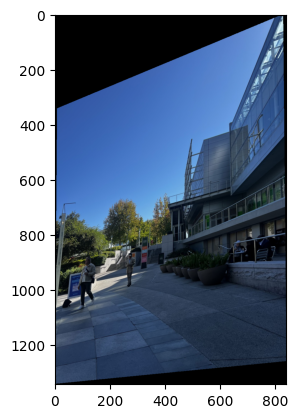

In [252]:
plt.imshow(warpedimg)

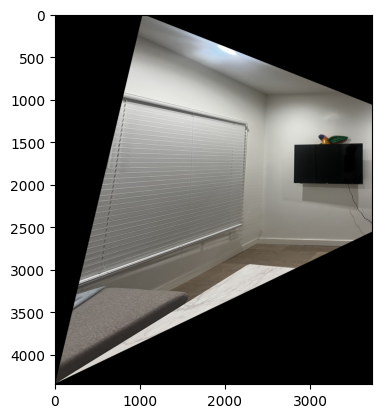

In [11]:
with open('square.json', 'r') as f:
    data = json.load(f)

im1_points = np.array(data["im2Points"])
im2_points = np.array(data["im1Points"])

homography2 = computeH(im1_points, im2_points)

img3 = plt.imread("images/img3.jpg")
warpedimg2 = warpImage(img3, homography2)
plt.imshow(warpedimg2[0])
plt.imsave("image_rectification.jpg", warpedimg2[0])

In [ ]:
with open('square.json', 'r') as f:
    data = json.load(f)

im1_points = np.array(data["im2Points"])
im2_points = np.array(data["im1Points"])

homography2 = computeH(im1_points, im2_points)

img3 = plt.imread("images/img3.jpg")
warpedimg2 = warpImage(img3, homography2)
plt.imshow(warpedimg2[0])
plt.imsave("image_rectification.jpg", warpedimg2[0])

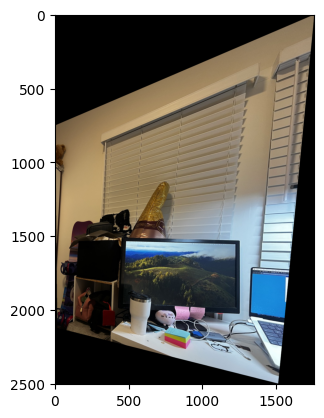

In [9]:
with open('square2.json', 'r') as f:
    data = json.load(f)

im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])

homography3 = computeH(im1_points, im2_points)

img4 = plt.imread("images/a.jpg")
warpedimg2 = warpImage(img4, homography3)
plt.imshow(warpedimg2[0])
plt.imsave("image_rectification_2.jpg", warpedimg2[0])

In [4]:
def mosaic(img1, img2, homography):
    
    warpedimg, bounding_box = warpImage(img1, homography)
    
    h1, w1 = warpedimg.shape[:2]
    h2, w2 = img2.shape[:2]
    x_shift = -bounding_box[0][0]
    y_shift = -bounding_box[0][1]
    
    res = np.zeros(((h1 + h2), (w1 + w2), 3))
    res[0:warpedimg.shape[0], 0:warpedimg.shape[1]] = warpedimg
    
    for y in range(h2):
        for x in range(w2):
            x_new, y_new = x + x_shift , y + y_shift
            res[y_new][x_new] = img2[y][x]
    
    if x_shift < 0:
        res = np.roll(res, -x_shift, axis=1)
    if y_shift < 0:
        res = np.roll(res, -y_shift, axis=0)
    
    return res.astype(np.uint8)

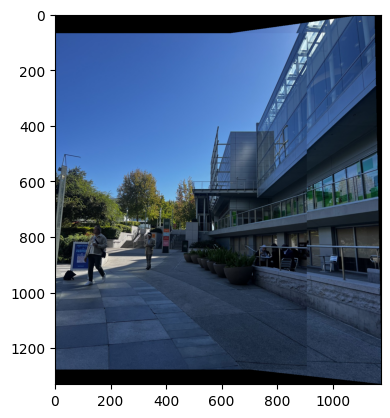

In [177]:
mosaic_image = mosaic(img1, img2, homography)
plt.imsave("merged_unsmooth.jpg", mosaic_image)
plt.imshow(mosaic_image)

In [27]:
def calculate_distance_transform(img1, img2):
    img1 = np.mean(img1, axis=2)
    img2 = np.mean(img2, axis=2)

    binary1 = img1 > np.mean(img1)
    binary2 = img2 > np.mean(img2)

    dist1 = ndimage.distance_transform_edt(binary1)
    dist2 = ndimage.distance_transform_edt(binary2)

    dist1 = (dist1 - np.min(dist1)) / (np.max(dist1) - np.min(dist1))
    dist2 = (dist2 - np.min(dist2)) / (np.max(dist2) - np.min(dist2))

    diff = np.abs(dist1 - dist2)

    return dist1, dist2, diff

In [168]:
dist1, dist2, diff = calculate_distance_transform(img1, img2)
plt.imsave("distance_trans_1.jpg", dist1, cmap = "gray")
plt.imsave("distance_trans_2.jpg", dist2, cmap = "gray")
plt.imsave("distance_trans_diff.jpg", diff, cmap = "gray")

In [33]:
def simple_blend(img1, img2, dist1, dist2, alpha=0.6, beta=0.4):
    # Ensure input images are float32
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # Low pass
    low_pass_img1 = cv2.GaussianBlur(img1, (5, 5), 1)
    low_pass_img2 = cv2.GaussianBlur(img2, (5, 5), 1)

    dist1_normalized = dist1 / (np.max(dist1) + 1e-6)
    dist2_normalized = dist2 / (np.max(dist2) + 1e-6)
    weights = dist1_normalized / (dist1_normalized + dist2_normalized + 1e-6)

    low_pass_blended = (weights[..., np.newaxis] * low_pass_img1 + 
                        (1 - weights[..., np.newaxis]) * low_pass_img2)

    # High pass
    high_pass_img1 = cv2.subtract(img1, low_pass_img1)
    high_pass_img2 = cv2.subtract(img2, low_pass_img2)

    high_mask = dist1 > dist2
    high_pass_blended = np.where(high_mask[..., np.newaxis], high_pass_img1, high_pass_img2)

    # Combine low and high frequency components
    final_image = cv2.addWeighted(low_pass_blended, alpha, high_pass_blended, beta, 0)
    final_image = np.clip(final_image, 0, 255).astype(np.uint8)

    return final_image

def mosaic_blend(img1, img2, homography):
    warpedimg, bounding_box = warpImage(img1, homography)
    
    h1, w1 = warpedimg.shape[:2]
    h2, w2 = img2.shape[:2]
    x_shift = -bounding_box[0][0]
    y_shift = -bounding_box[0][1]
    
    h_total = max(h1, h2 + y_shift)
    w_total = max(w1, w2 + x_shift)
    canvas1 = np.zeros((h_total, w_total, 3), dtype=np.float32)
    canvas2 = np.zeros((h_total, w_total, 3), dtype=np.float32)
    
    canvas1[0:h1, 0:w1] = warpedimg.astype(np.float32)
    
    y_start = max(0, y_shift)
    x_start = max(0, x_shift)
    canvas2[y_start:y_start+h2, x_start:x_start+w2] = img2.astype(np.float32)
    
    # Compute distance transforms
    gray1 = cv2.cvtColor(canvas1.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(canvas2.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    _, binary1 = cv2.threshold(gray1, 1, 255, cv2.THRESH_BINARY)
    _, binary2 = cv2.threshold(gray2, 1, 255, cv2.THRESH_BINARY)
    dist1 = cv2.distanceTransform(binary1, cv2.DIST_L2, 5)
    dist2 = cv2.distanceTransform(binary2, cv2.DIST_L2, 5)
    
    dist1 = cv2.GaussianBlur(dist1, (21, 21), 5)
    dist2 = cv2.GaussianBlur(dist2, (21, 21), 5)
    
    blended = simple_blend(canvas1, canvas2, dist1, dist2)
    
    return blended

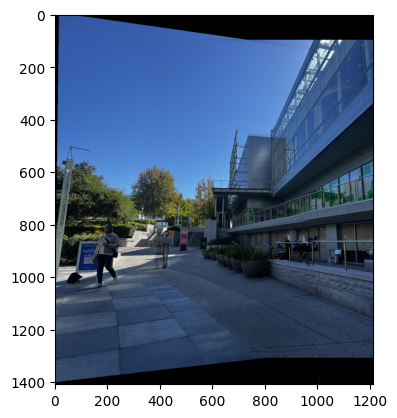

In [26]:
res = mosaic_blend(img1, img2, H)
plt.imshow(res)
plt.imsave("2_blend.png", res)

In [ ]:
with open('correspondance2.json', 'r') as f:
    data = json.load(f)

im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])
img1 = plt.imread("images/1.jpg")
img2 = plt.imread("images/2.jpg")

H, _ = computeH(im1_points, im2_points)
res = mosaic_blend(img1, img2, H)

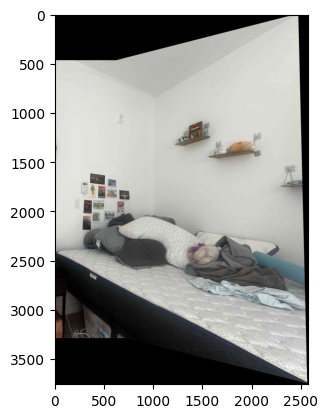

In [34]:
plt.imshow(res2)
plt.imsave("res2.png", res2)

In [ ]:
with open('correspondance3.json', 'r') as f:
    data = json.load(f)

im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])
img1 = plt.imread("images/c.jpg")
img2 = plt.imread("images/d.jpg")
H, _ = computeH(im1_points, im2_points)
res3 = mosaic_blend(img1, img2, H)

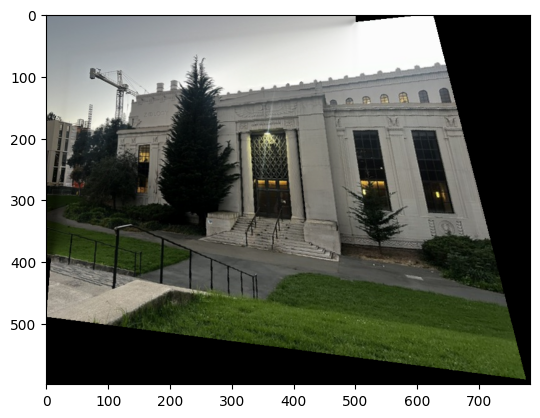

In [18]:
plt.imshow(res3)
plt.imsave("output3.png", res3)

In [6]:
def get_harris_corners(im, edge_discard=20, threshold=0.2):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=2)
    h[h < threshold] = 0
    coords = peak_local_max(h, min_distance=1)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


def dist2(x, c):
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert(dimx == dimc, 'Data dimension does not match dimension of centers')

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)

<>:33: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:33: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/var/folders/4s/66z0r0jx3_v86ztl39l2c07m0000gn/T/ipykernel_20394/3789224660.py:33: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(dimx == dimc, 'Data dimension does not match dimension of centers')


In [57]:
image_path = "./images/pic1.jpg"
image = io.imread(image_path)

bw_image = color.rgb2gray(image)
harris_h, harris_coords = get_harris_corners(bw_image, 20, 0.1)

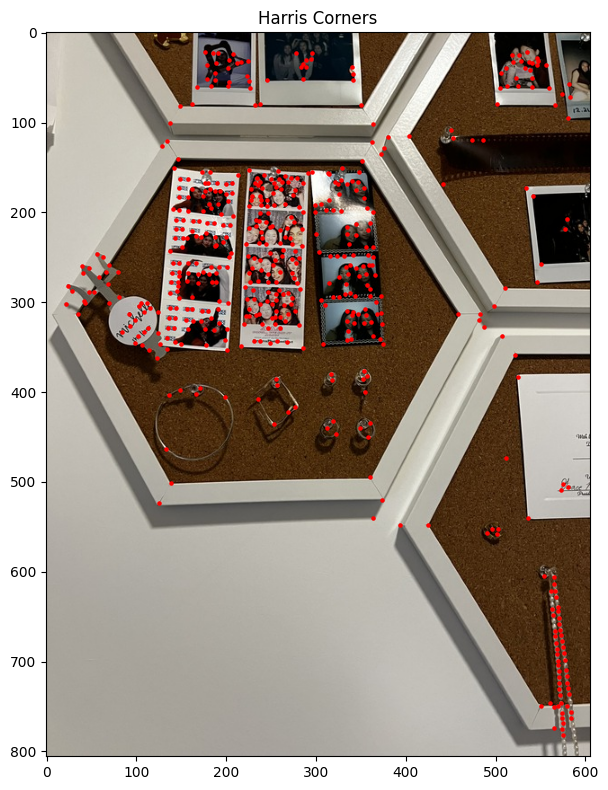

In [58]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image)
ax.scatter(harris_coords[1], harris_coords[0], c='r', s=5, marker='o')

ax.set_title('Harris Corners')

plt.tight_layout()
plt.savefig("./partb/harris_corners_3.jpg", bbox_inches='tight') 
plt.show()

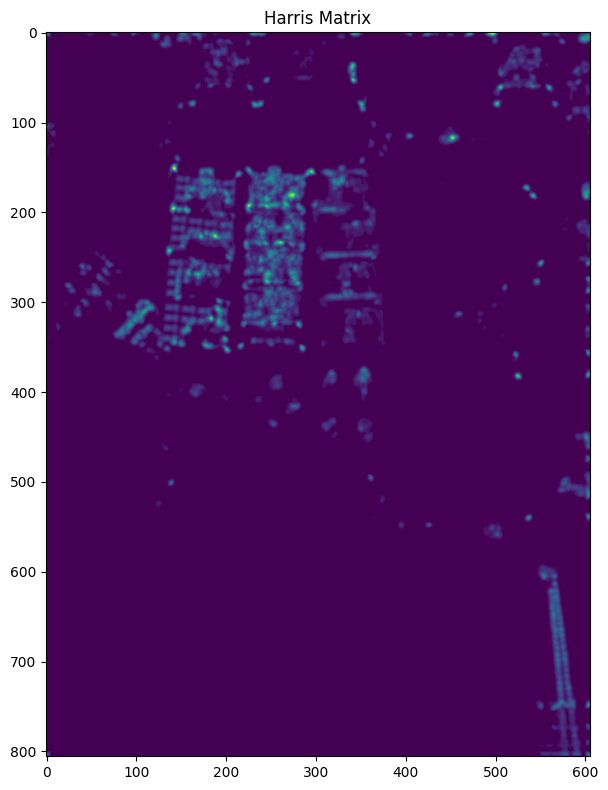

In [59]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(harris_h)

ax.set_title('Harris Matrix')

plt.tight_layout()
plt.savefig("./partb/harris_matrix_3.jpg", bbox_inches='tight') 
plt.show()

In [60]:
def anms(h, coords, thres=20):
    coords = coords.T 
    
    valid_mask = (coords[:, 0] < h.shape[0]) & (coords[:, 1] < h.shape[1])
    coords = coords[valid_mask]

    keypoints = np.column_stack((coords, h[coords[:, 0], coords[:, 1]]))
    coords = keypoints[:, :2]
    responses = keypoints[:, 2]
    
    distances = dist2(coords, coords)
    
    radii = np.full(len(keypoints), np.inf)
    
    for i in range(len(keypoints)):
        for j in range(len(keypoints)):
            if responses[j] > responses[i]:
                radii[i] = min(radii[i], distances[i, j])

    indices = np.argsort(radii)[::-1]
    
    selected_indices = indices[:thres]
    coords = coords[selected_indices]
    
    return h, coords.T

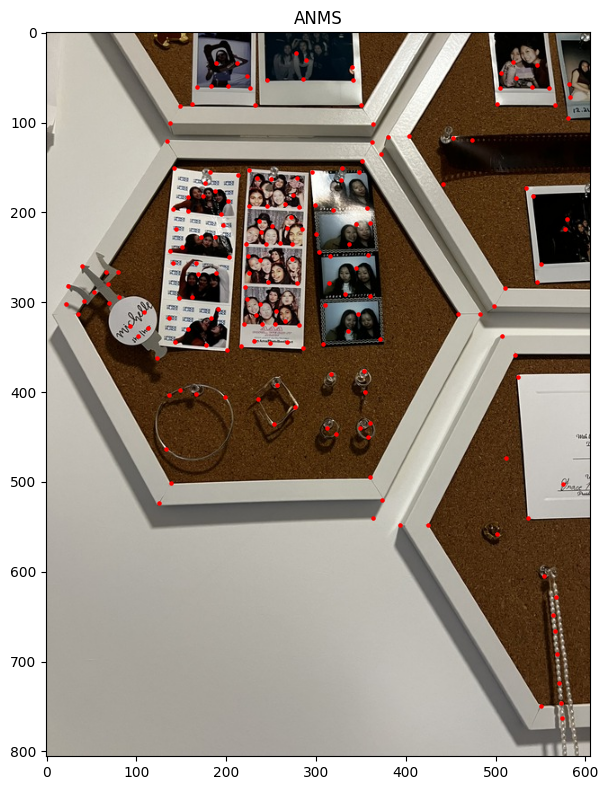

In [61]:
h, coords = anms(harris_h, harris_coords, 200)
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image)
ax.scatter(coords[1], coords[0], c='r', s=5, marker='o')

ax.set_title('ANMS')

plt.tight_layout()
plt.savefig("./partb/anms_3.jpg", bbox_inches='tight') 
plt.show()

In [65]:
def extract_and_normalize_features(image, coords, patch_radius=20, feature_spacing=5, sigma=5):
    blurred_image = gaussian(image, sigma=(sigma, sigma), channel_axis=2)
    
    patch_size = 2 * patch_radius + 1
    feature_size = patch_size // feature_spacing + 1
    
    features = []
    
    for y, x in coords.T:
        y, x = int(y), int(x)
        
        if (y - patch_radius >= 0 and y + patch_radius < image.shape[0] and 
            x - patch_radius >= 0 and x + patch_radius < image.shape[1]):
            patch = blurred_image[y-patch_radius:y+patch_radius+1, x-patch_radius:x+patch_radius+1, :]
            
            sampled_patch = patch[::feature_spacing, ::feature_spacing, :]
            
            feature = sampled_patch.reshape(-1)
            
            for c in range(3):
                channel_data = feature[c::3]
                feature[c::3] = (channel_data - np.mean(channel_data)) / (np.std(channel_data) + 1e-7)
            
            features.append(feature)
    
    return np.array(features)

def display(features, num_features = 5):
    fig, axes = plt.subplots(1, num_features, figsize=(15, 3))
    feature_size = int(np.sqrt(len(features[0]) // 3))
    
    for i in range(num_features):
        feature = features[i].reshape(feature_size, feature_size, 3)
        
        feature = (feature - feature.min()) / (feature.max() - feature.min())
        
        axes[i].imshow(feature)
        axes[i].set_title(f'Feature {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig("./partb/patches_3.jpg", bbox_inches='tight')
    plt.show()

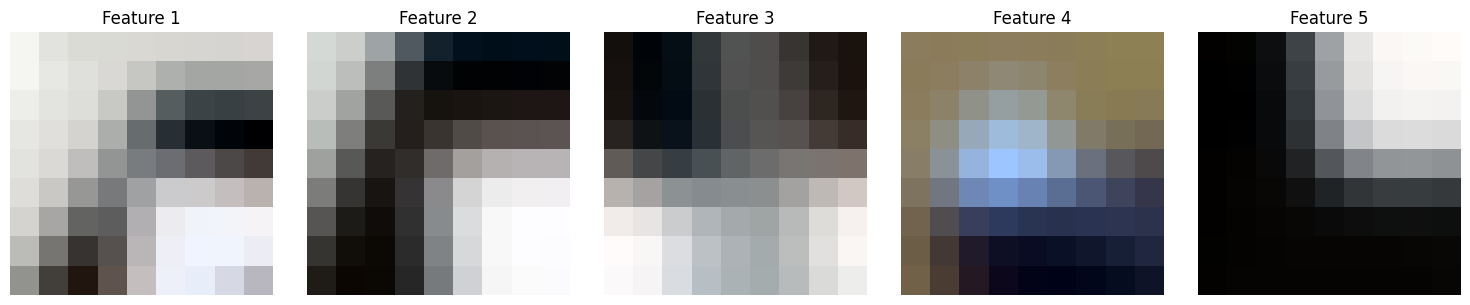

In [66]:
features_1 = extract_and_normalize_features(image, coords)
display(features_1)

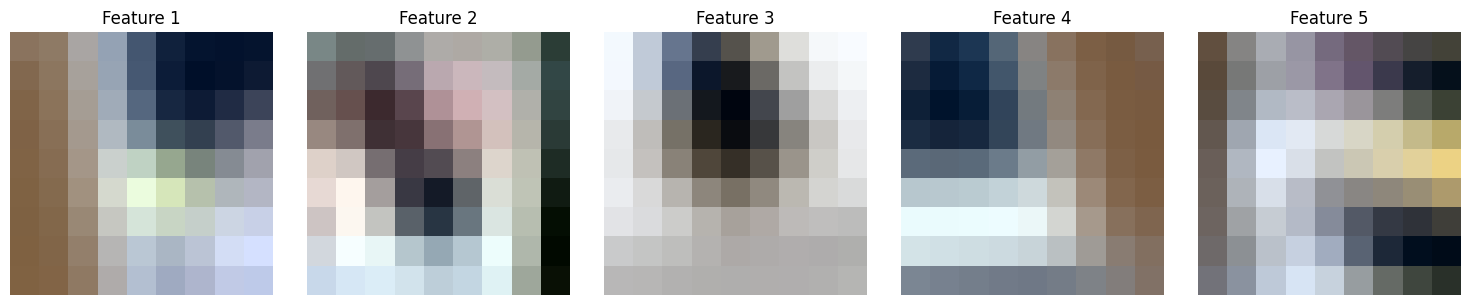

In [67]:
def getFeatures(imgpath):
    image = io.imread(imgpath)
    bw_image = color.rgb2gray(image)
    harris_h, harris_coords = get_harris_corners(bw_image, 20, 0.1)
    anms_h, anms_coords = anms(harris_h, harris_coords, 200)
    features = extract_and_normalize_features(image, anms_coords)
    return anms_coords, features
    
image_path = "./images/pic2.jpg"
image_2 = io.imread(image_path)
coords_2, features_2 = getFeatures(image_path)
display(features_2)

In [68]:
def match_finder(features1, features2, ratio_threshold=0.75):
    kdtree2 = KDTree(features2)
    matches = []
    
    for i, feature in enumerate(features1):
        distances, indices = kdtree2.query([feature], k=2)
        
        dist1, dist2 = distances[0]
        idx1, idx2 = indices[0]
        
        # Ratio test
        if dist1 / dist2 < ratio_threshold:
            matches.append((i, idx1))
    
    return np.array(matches)

# Now let's use this function
matched_features = match_finder(features_1, features_2)

In [69]:
matched_coords_1 = coords[:, matched_features[:, 0]]
matched_coords_2 = coords_2[:, matched_features[:, 1]]

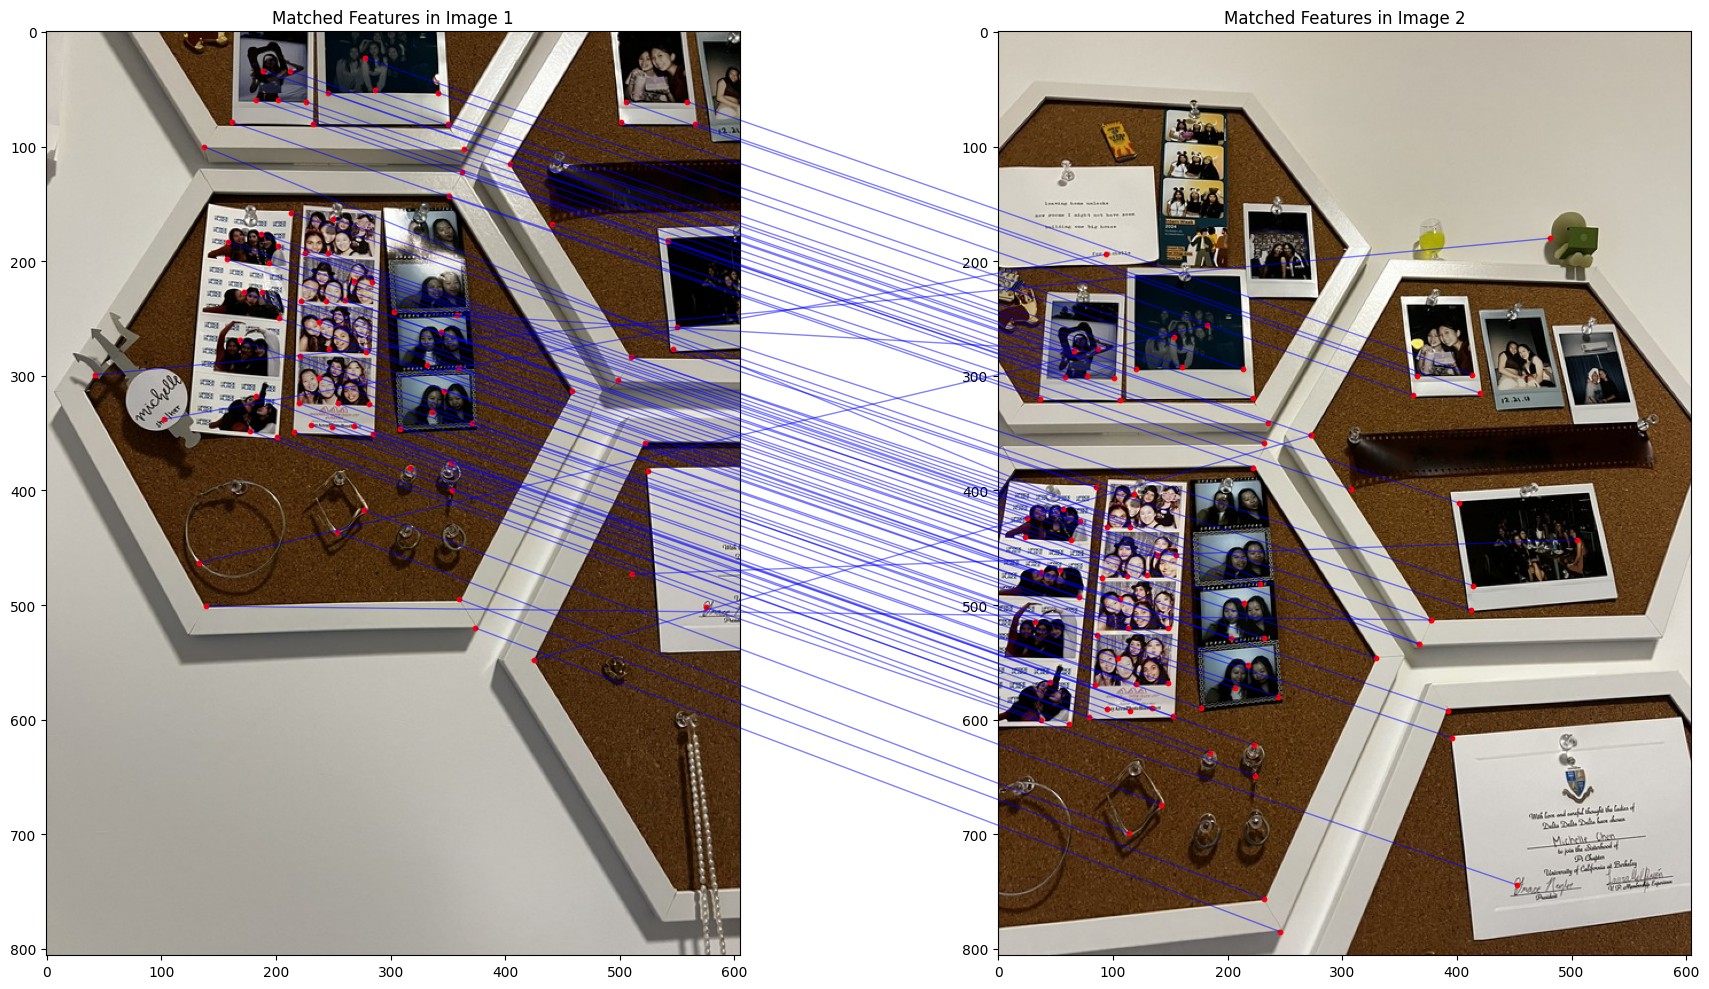

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(image)
ax2.imshow(image_2)

ax1.scatter(matched_coords_1[1], matched_coords_1[0], c='r', s=10)
ax2.scatter(matched_coords_2[1], matched_coords_2[0], c='r', s=10)

# Draw lines between corresponding points
for (y1, x1), (y2, x2) in zip(matched_coords_1.T, matched_coords_2.T):
    con = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA="data", coordsB="data",
                              axesA=ax1, axesB=ax2, color="blue", linewidth=1, alpha=0.5)
    fig.add_artist(con)

ax1.set_title('Matched Features in Image 1')
ax2.set_title('Matched Features in Image 2')

plt.tight_layout()
plt.savefig("./partb/matching_features_3.jpg", bbox_inches='tight') 
plt.show()

In [146]:
def get_inliers_by_distance(pts1, pts2, e=1):
    distances = np.sqrt(np.sum((pts1 - pts2)**2, axis=0))
    inliers_indices = np.where(distances < e)[0]
    return inliers_indices

In [147]:
def ransac(matched_coords_1, matched_coords_2, reproj_thresh=5.0, iterations=1000, inliers_thresh=0.7):
    max_inliers = []
    best_H = None
    
    for _ in range(iterations):
        try:
            random_4_index = random.sample(range(matched_coords_1.shape[1]), 4)
            rnd_pairs1 = matched_coords_1[:, random_4_index].T
            rnd_pairs2 = matched_coords_2[:, random_4_index].T
            
            H = cv2.getPerspectiveTransform(rnd_pairs1.astype(np.float32), rnd_pairs2.astype(np.float32))
            
            ones = np.ones((1, matched_coords_1.shape[1]))
            homogeneous_coords = np.vstack((matched_coords_1, ones))
            transformed_coords = H @ homogeneous_coords
            transformed_coords = transformed_coords[:2, :] / transformed_coords[2, :]
            
            inlier_indices = get_inliers_by_distance(transformed_coords, matched_coords_2, reproj_thresh)
            
            current_inliers = list(zip(matched_coords_1[:, inlier_indices].T, 
                                       matched_coords_2[:, inlier_indices].T))
            
            if len(inlier_indices) > len(max_inliers):
                max_inliers = current_inliers
                best_H = H
            
            if len(inlier_indices) > (matched_coords_1.shape[1] * inliers_thresh):
                break
        except np.linalg.LinAlgError:
            continue
    return best_H, max_inliers

In [142]:
H, ransac_matches = ransac(matched_coords_1, matched_coords_2)

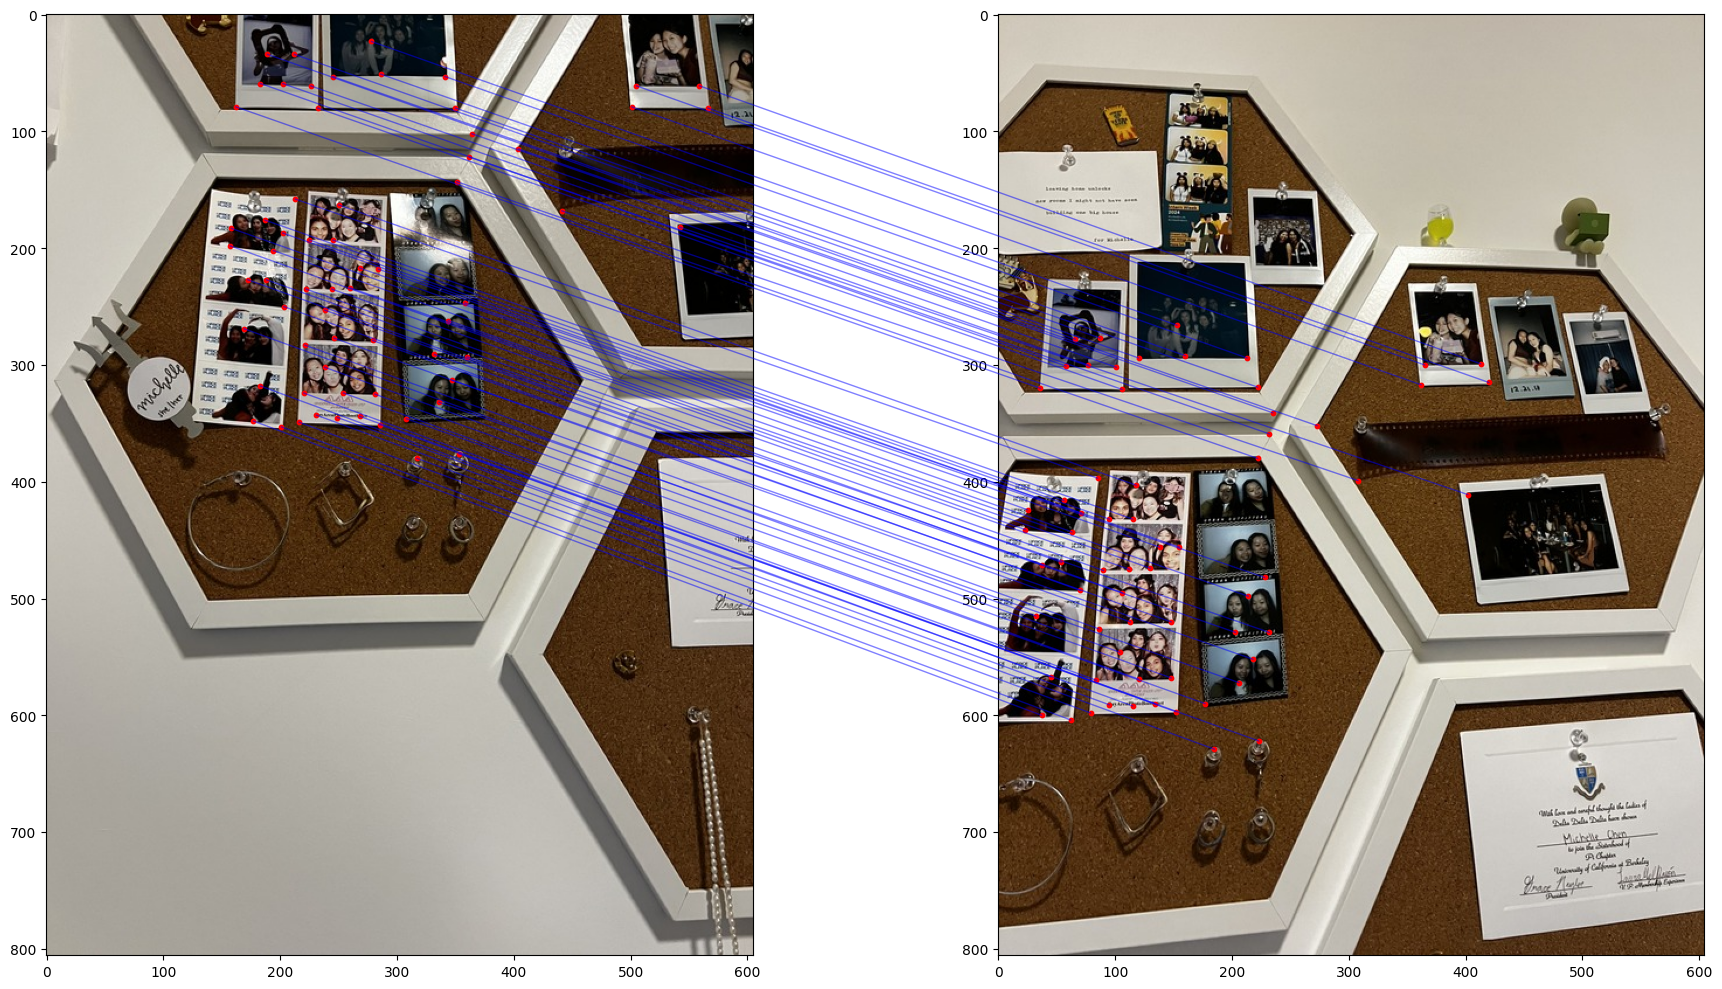

In [145]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image)
ax2.imshow(image_2)

for pt1, pt2 in ransac_matches:
    y1, x1 = pt1
    y2, x2 = pt2
    ax1.scatter(x1, y1, c='r', s=10)
    ax2.scatter(x2, y2, c='r', s=10)
    con = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="blue", linewidth=1, alpha=0.5)
    fig.add_artist(con)
plt.tight_layout()
plt.savefig("./partb/ransac_features_3.jpg", bbox_inches='tight') 
plt.show()

In [150]:
res = mosaic_blend(image, image_2, H)

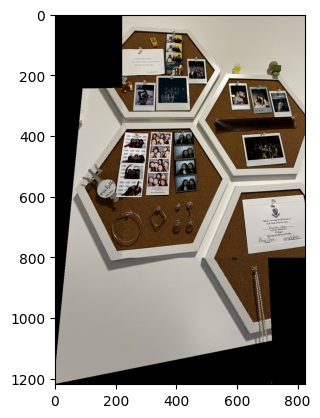

In [90]:
plt.imshow(res)
plt.imsave("pic_merged.png", res)

In [149]:
def automatic_mosaic(img1_pth, img2_pth):
    coords_1, features_1 = getFeatures(img1_pth)
    coords_2, features_2 = getFeatures(img2_pth)
    img1 = io.imread(img1_pth)
    img2 = io.imread(img2_pth)
    matched_features = match_finder(features_1, features_2)
    matched_coords_1 = coords_1[:, matched_features[:, 0]]
    matched_coords_2 = coords_2[:, matched_features[:, 1]]
    ransac_matches, H = ransac(matched_coords_1, matched_coords_2)
    res = mosaic_blend(img1, img2, H)
    return res

In [152]:
img1_pth = "./images/camp1.jpg"
img2_pth = "./images/camp2.jpg"
image1 = io.imread(img1_pth)
image2 = io.imread(img2_pth)

In [ ]:
H = automatic_mosaic(img1_pth, img2_pth)
res = mosaic_blend(image1, image2, H)

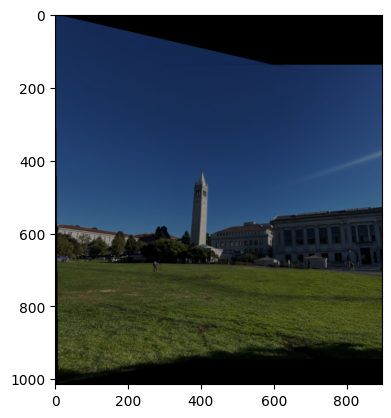

In [153]:
plt.imshow(res)
plt.imsave("campinile_merge.png", res)

In [186]:
img1_pth = "./images/fridge_1.jpg"
img2_pth = "./images/fridge_2.jpg"
res2 = automatic_mosaic(img1_pth, img2_pth)

In [187]:
image1 = io.imread(img1_pth)
image2 = io.imread(img2_pth)
res2 = mosaic_blend(image1, image2, res2)

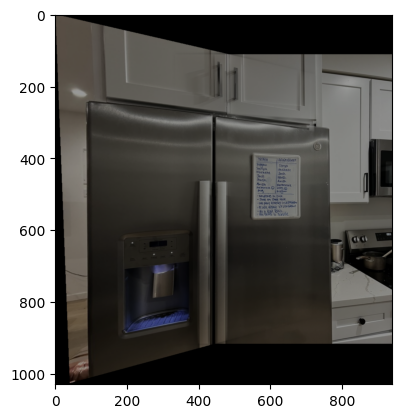

In [189]:
plt.imshow(res2)
plt.imsave("combined_fridge.png", res2)